# Merge Table

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import time
import warnings
#Visual
import altair as alt
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set()

# ML library
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# cluster
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

# PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA 
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import SparsePCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. For more information, see the blog post accompanying its public release.

In this competition, Instacart is challenging the Kaggle community to use this anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order. They’re not only looking for the best model, Instacart’s also looking for machine learning engineers to grow their team.

For each orderid in the test set, you should predict a space-delimited list of productids for that order. If you wish to predict an empty order, you should submit an explicit 'None' value. You may combine 'None' with product_ids. The spelling of 'None' is case sensitive in the scoring metric. The file should have a header and look like the following:

In [3]:
from sklearn.utils import shuffle
prior = pd.read_csv('/content/drive/My Drive/Data/Instacart Market dataset/order_products__prior.csv')
prior = prior[0:10000000].reset_index()
prior.head()

,index,order_id,product_id,add_to_cart_order,reordered
0,0,2,33120,1,1
1,1,2,28985,2,1
2,2,2,9327,3,0
3,3,2,45918,4,1
4,4,2,30035,5,0


In [4]:
prior.shape

(10000000, 5)

In [5]:
train = pd.read_csv('/content/drive/My Drive/Data/Instacart Market dataset/order_products__train.csv')
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [0]:
train.shape

(1384617, 4)

In [0]:
order_products_all = pd.concat([prior, train], axis=0)
order_products_all.shape

(11384617, 5)

Firstly, let’s explore the data for Instacart products. There are 2 CSV files, namely order_products_train and order_products_prior, that specify which products were purchased in each order. More specifically, order_products_prior contains previous order products for all customers and order_products_train contains the latest order products for some customers only.

* The ID of the order (order_id)
* The ID of the product (product_id)
* The ordering of that product in the order (add_to_cart_order)
* Whether that product was reordered (reordered).

In [0]:
orders = pd.read_csv('/content/drive/My Drive/Data/Instacart Market dataset/orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [0]:
orders.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

* The ID of the order (order_id)
* The ID of the customer (user_id)
* Which evaluation datasets that the order is in — prior, train, or test (eval_set)
* The number of the order (order_number)
* The day of the week when that order occurred (order_dow)
* The hour of the day when that order occurred (order_hour_of_day)
* The number of days since the previous order (days_since_prior_order)

This is my undrstanding of the dataset structur:

users are identified by user_id in the orders csv file. Each row of the orders csv fil represents an order made by a user. Order are identified by order_id;

Each order of a user is characterized by an order_number which specifies when it has been made with respect to the others of the same user;

each order consists of a set of product each characterized by an add_to_cart_order feature representing the sequence in which they have been added to the cart in that order;

for each user we may have n-1 prior orders and 1 train order OR n-1 prior orders and 1 test order in which we have to state what products have been reordered.

In [0]:
print(orders.shape)
print(prior.shape)
print(train.shape)

(3421083, 7)
(10000000, 5)
(1384617, 4)


In [0]:
products = pd.read_csv('/content/drive/My Drive/Data/Instacart Market dataset/products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [0]:
aisles = pd.read_csv('/content/drive/My Drive/Data/Instacart Market dataset/aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [0]:
departments = pd.read_csv('/content/drive/My Drive/Data/Instacart Market dataset/departments.csv')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [0]:
print(orders.shape)
print(prior.shape)
print(train.shape)
print(products.shape)
print(aisles.shape)
print(departments.shape)

(3421083, 7)
(10000000, 5)
(1384617, 4)
(49688, 4)
(134, 2)
(21, 2)


In [0]:
a = pd.merge(order_products_all,products, on = ['product_id','product_id'])
a = pd.merge(a,orders,on=['order_id','order_id'])

In [0]:
a = pd.merge(a,departments,on=['department_id','department_id'])
df_all = pd.merge(a,aisles,on=['aisle_id','aisle_id'])
df_all.head(5)

,index,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
0,0.0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,dairy eggs,eggs
1,237.0,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,dairy eggs,eggs
2,1084.0,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,dairy eggs,eggs
3,3039.0,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,dairy eggs,eggs
4,3709.0,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,dairy eggs,eggs


In [0]:
df_all.shape

(11384617, 16)

In [0]:
df_all['eval_set'].value_counts()

prior    10000000
train     1384617
Name: eval_set, dtype: int64

In [0]:
df_all.isnull().sum()

index                     1384617
order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order     643267
department                      0
aisle                           0
dtype: int64

In [0]:
df_all.columns

Index(['index', 'order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'user_id', 'eval_set',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'department', 'aisle'],
      dtype='object')

# Cluster and PCA from DNN

In [0]:
print(df_all.shape)
df_all.head()

(11384617, 16)


,index,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
0,0.0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,dairy eggs,eggs
1,237.0,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,dairy eggs,eggs
2,1084.0,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,dairy eggs,eggs
3,3039.0,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,dairy eggs,eggs
4,3709.0,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,dairy eggs,eggs


In [0]:
df_all.count(axis=0) #Count not null value in each columns

index                     10000000
order_id                  11384617
product_id                11384617
add_to_cart_order         11384617
reordered                 11384617
product_name              11384617
aisle_id                  11384617
department_id             11384617
user_id                   11384617
eval_set                  11384617
order_number              11384617
order_dow                 11384617
order_hour_of_day         11384617
days_since_prior_order    10741350
department                11384617
aisle                     11384617
dtype: int64

In [0]:
df_all.nunique()

index                     10000000
order_id                   1122923
product_id                   48907
add_to_cart_order              137
reordered                        2
product_name                 48907
aisle_id                       134
department_id                   21
user_id                     199381
eval_set                         2
order_number                   100
order_dow                        7
order_hour_of_day               24
days_since_prior_order          31
department                      21
aisle                          134
dtype: int64

In [0]:
userid_aisle = pd.crosstab(df_all['user_id'], df_all['aisle'])
print(userid_aisle.shape)
userid_aisle.head()

(199381, 134)


aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,3,0,0,1,0,0,0,4,0,0,0,0,0,0,0,3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,7
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
5,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
userid_reorder = pd.crosstab(df_all['user_id'], df_all['reordered'])
print(userid_reorder.shape)
userid_reorder.head()

(199381, 2)


reordered,0,1
user_id,,
1,6,23
2,44,32
3,7,13
4,8,1
5,9,12


In [0]:
userid_days_since = pd.crosstab(df_all['user_id'], df_all['days_since_prior_order'])
print(userid_days_since.shape)
userid_days_since.head()

(196251, 31)


days_since_prior_order,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,5,5,0,0,0,0,0,0,8,0,0
2,0,0,0,0,0,0,0,0,13,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,31
3,0,0,0,0,0,0,0,0,0,9,0,5,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0


In [0]:
userid_order_dow = pd.crosstab(df_all['user_id'], df_all['order_dow'])
print(userid_order_dow.shape)
userid_order_dow.head()

(199381, 7)


order_dow,0,1,2,3,4,5,6
user_id,,,,,,,
1,0,5,0,5,19,0,0
2,0,47,13,16,0,0,0
3,5,0,0,15,0,0,0
4,0,0,0,0,7,2,0
5,9,12,0,0,0,0,0


In [0]:
userid_order_hour = pd.crosstab(df_all['user_id'], df_all['order_hour_of_day'])
print(userid_order_hour.shape)
userid_order_hour.head()

(199381, 24)


order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
user_id,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,11,5,0,0,5,0,0,8,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,29,31,0,0,0,16,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,5,9,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,7,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,12,0,0,0,0,0


In [0]:
a1 = pd.merge(userid_aisle,userid_reorder,on=['user_id'])
a1.shape

(199381, 136)

In [0]:
a2=pd.merge(a1,userid_days_since,on=['user_id'])
a3=pd.merge(a2,userid_order_dow,on=['user_id'])
a4=pd.merge(a3,userid_order_hour,on=['user_id'])
a4.shape

(196251, 198)

In [0]:
a4.head()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,22.0_x,23.0_x,24.0,25.0,26.0,27.0,28.0,29.0,30.0,0_x,1_x,2_y,3_y,4_y,5_y,6_y,0_y,1_y,2,3,4,5,6,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y,20_y,21_y,22_y,23_y
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,8,0,0,0,5,0,5,19,0,0,0,0,0,0,0,0,0,0,11,5,0,0,5,0,0,8,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,1,0,0,0,0,0,...,0,0,0,0,0,16,0,0,31,0,47,13,16,0,0,0,0,0,0,0,0,0,0,0,0,0,29,31,0,0,0,16,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,5,9,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,7,0,0,0,0,0,0,0,0
5,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,12,0,0,0,0,0


In [0]:
data=a4.copy()
data.to_csv('data_instacart.csv')

# Dimension reduction

## PCA

Explore all features

In [0]:
data=pd.read_csv("/content/drive/My Drive/Data/data_instacart.csv")

In [0]:
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(data)
print(X_scaled.shape)
X_scaled

(196251, 199)


array([[-1.7318438 , -0.11216385, -0.30175926, ..., -0.23989491,
        -0.21515543, -0.17816002],
       [-1.731827  , -0.11216385,  0.71349089, ..., -0.23989491,
        -0.21515543, -0.17816002],
       [-1.7318102 , -0.11216385, -0.30175926, ..., -0.23989491,
        -0.21515543, -0.17816002],
       ...,
       [ 1.73174891, -0.11216385, -0.30175926, ..., -0.23989491,
        -0.21515543, -0.17816002],
       [ 1.7317657 , -0.11216385,  0.71349089, ..., -0.23989491,
        -0.21515543,  0.81072709],
       [ 1.7317825 , -0.11216385,  0.71349089, ..., -0.23989491,
        -0.21515543, -0.17816002]])

In [0]:
# No choose component, default max component
pca = PCA()
X_train_pca = pca.fit_transform(X_scaled)
X_train_pca.shape

(196251, 198)

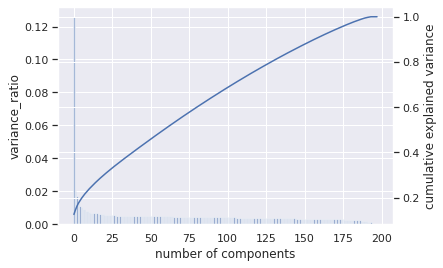

In [0]:
a=pd.DataFrame(pca.explained_variance_ratio_,columns=['value'])

f,ax=plt.subplots()
ax.bar(a.index,a.value, alpha=0.5, align='center')
ax1=ax.twinx()
ax1.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel('number of components')
ax1.set_ylabel('cumulative explained variance')
ax.set_ylabel('variance_ratio')
plt.show()

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 174 components to retain 95% of the variance. Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

Choosing the Right Number of Dimensions

In [0]:
# Method 1
pca = PCA()
pca.fit(X_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

174

In [0]:
# Method 2
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_scaled)
pca.n_components_

174

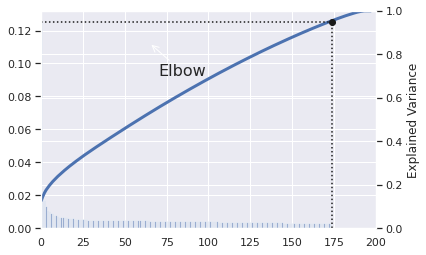

In [0]:
b=pd.DataFrame(pca.explained_variance_ratio_,columns=['value'])

f,ax=plt.subplots()
ax.bar(b.index,b.value, alpha=0.5, align='center')
ax1=ax.twinx()
ax1.plot(cumsum, linewidth=3)
ax1.axis([0, 200, 0, 1])
ax1.set_xlabel("Dimensions")
ax1.set_ylabel("Explained Variance")
ax1.plot([d, d], [0, 0.95], "k:")
ax1.plot([0, d], [0.95, 0.95], "k:")
ax1.plot(d, 0.95, "ko")
ax1.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

In [0]:
components=174

In [0]:
pca = PCA(n_components=174)
X_train_pca = pca.fit_transform(X_scaled)
X_train_pca.shape

(196251, 174)

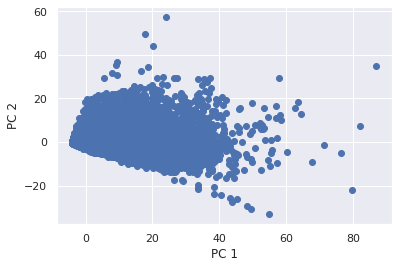

In [0]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

# Clustering

## K-Means

Choosing the right number of Cluster

In [0]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, batch_size=10000, random_state=42)
t1 = time.time()
minibatch_kmeans.fit(X_train_pca)
t2 = time.time()
print('minibatch_kmeans: {:.3f} seconds'.format(t2-t1))

kmean = KMeans(n_clusters=5,random_state=42)
t1 = time.time()
kmean.fit(X_train_pca)
t2 = time.time()
print('kmean: {:.3f} seconds'.format(t2-t1))

minibatch_kmeans: 2.580 seconds
kmean: 48.646 seconds


In [0]:
k_range = range(2,15)
kmeans_per_k = []
for k in k_range:
    print(k)
    t1 = time.time()
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, batch_size=10000, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(minibatch_kmeans)
    t2 = time.time()
    print('{:.3f} seconds'.format(t2-t1))

2
2.631 seconds
3
2.413 seconds
4
2.566 seconds
5
2.630 seconds
6
2.708 seconds
7
2.822 seconds
8
2.900 seconds
9
2.955 seconds
10
2.726 seconds
11
3.126 seconds
12
3.054 seconds
13
2.083 seconds
14
3.227 seconds


In [0]:
distortions = []
for model in kmeans_per_k:
    distortions.append(model.inertia_)
distortions

[33934505.65151078,
 33077225.462732177,
 32793467.00280805,
 32605327.56836486,
 32332525.6314215,
 32249484.711929437,
 31940159.433228016,
 31729943.755667247,
 32130564.22132872,
 31778327.58803715,
 31694450.42216722,
 31741696.41285342,
 31319047.628532052]

In [0]:
len(kmeans_per_k)

13

In [0]:
X = np.linspace(2, len(kmeans_per_k)+1, len(kmeans_per_k))
X

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.])

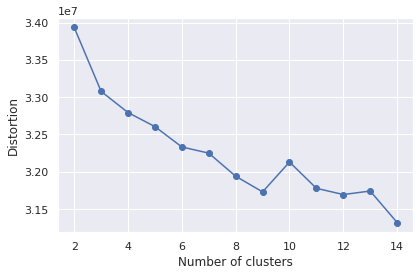

In [0]:
plt.plot(X, distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('images/11_03.png', dpi=300)
plt.show()

In [0]:
best_k=9
best_model = kmeans_per_k[best_k-2]
best_model

MiniBatchKMeans(batch_size=10000, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=9, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

silhouette_score Very long

from sklearn.metrics import silhouette_score
silhouette_scores_list=[]

for model in kmeans_per_k:
  t1=time.time()
  print(model)
  silhouette_score(X_train_pca, model.labels_)
  silhouette_scores_list.append(silhouette_score)
  t2=time.time()
  print('kmean: {:.3f} seconds'.format(t2-t1))

best_index = np.argmax(silhouette_scores_list)
best_k = k_range[best_index]
best_score = silhouette_scores_list[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores_list, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [0]:
def plot_centroids(centroids, weights=None, circle_color='black', cross_color='r'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

{0, 1, 2, 3, 4, 5, 6, 7, 8}


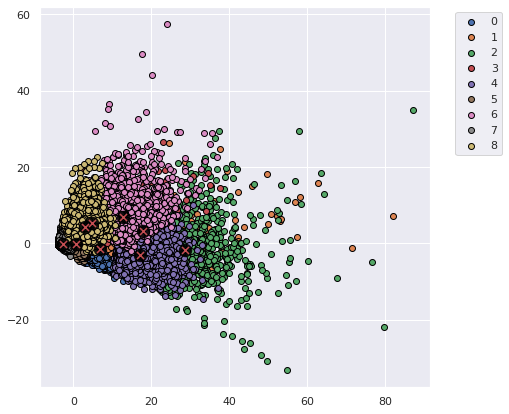

In [0]:
#ac.fit(X_scaled)
clusters_number=best_k
cluster=best_model.predict(X_train_pca)

unique_labels = set(cluster)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
print(unique_labels)
#print(colors)

fig,ax=plt.subplots(figsize=(7,7))
for k in range(clusters_number):
  plt.scatter(X_train_pca[cluster==k, 0],X_train_pca[cluster==k, 1], 
              edgecolor='black',marker='o',label=k)
plot_centroids(best_model.cluster_centers_) # Plot center
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [0]:
data['cluster'] = best_model.predict(X_train_pca)
data.head()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,23.0_x,24.0,25.0,26.0,27.0,28.0,29.0,30.0,0_x,1_x,2_y,3_y,4_y,5_y,6_y,0_y,1_y,2,3,4,5,6,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y,20_y,21_y,22_y,23_y,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,8,0,0,0,5,0,5,19,0,0,0,0,0,0,0,0,0,0,11,5,0,0,5,0,0,8,0,0,0,0,0,0,0,0,7
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,1,0,0,0,0,0,...,0,0,0,0,16,0,0,31,0,47,13,16,0,0,0,0,0,0,0,0,0,0,0,0,0,29,31,0,0,0,16,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,5,9,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,7,0,0,0,0,0,0,0,0,7
5,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,12,0,0,0,0,0,7


In [0]:
data.cluster.value_counts()

7    114936
5     48320
0     16739
8      7304
4      4243
6      2439
2      1057
1       687
3       526
Name: cluster, dtype: int64

# Clustering for visual and outlier detection (PCA=2)

In [0]:
data=pd.read_csv("/content/drive/My Drive/Data/data_instacart.csv")
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(data)
print(X_scaled.shape)
X_scaled

(196251, 199)


array([[-1.7318438 , -0.11216385, -0.30175926, ..., -0.23989491,
        -0.21515543, -0.17816002],
       [-1.731827  , -0.11216385,  0.71349089, ..., -0.23989491,
        -0.21515543, -0.17816002],
       [-1.7318102 , -0.11216385, -0.30175926, ..., -0.23989491,
        -0.21515543, -0.17816002],
       ...,
       [ 1.73174891, -0.11216385, -0.30175926, ..., -0.23989491,
        -0.21515543, -0.17816002],
       [ 1.7317657 , -0.11216385,  0.71349089, ..., -0.23989491,
        -0.21515543,  0.81072709],
       [ 1.7317825 , -0.11216385,  0.71349089, ..., -0.23989491,
        -0.21515543, -0.17816002]])

In [0]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_scaled)
X_train_pca.shape

(196251, 2)

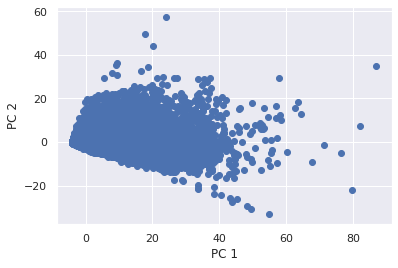

In [0]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

# Minibatch_kmeans

In [0]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, batch_size=10000, random_state=42)
t1 = time.time()
minibatch_kmeans.fit(X_train_pca)
t2 = time.time()
print('minibatch_kmeans: {:.3f} seconds'.format(t2-t1))

kmean = KMeans(n_clusters=5,random_state=42)
t1 = time.time()
kmean.fit(X_train_pca)
t2 = time.time()
print('kmean: {:.3f} seconds'.format(t2-t1))

In [0]:
k_range = range(2,15)
kmeans_per_k = []
for k in k_range:
    #print(k)
    t1 = time.time()
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, batch_size=10000, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(minibatch_kmeans)
    t2 = time.time()
    #print('{:.3f} seconds'.format(t2-t1))

In [0]:
distortions = []
for model in kmeans_per_k:
    distortions.append(model.inertia_)
#distortions

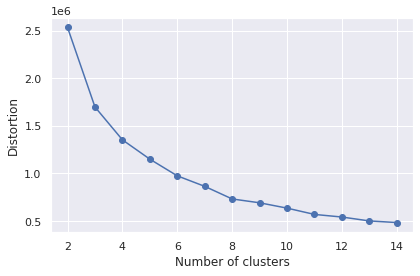

In [0]:
X = np.linspace(2, len(kmeans_per_k)+1, len(kmeans_per_k))

plt.plot(X, distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('images/11_03.png', dpi=300)
plt.show()

In [0]:
best_k=5
best_model = kmeans_per_k[best_k-2]
best_model

MiniBatchKMeans(batch_size=10000, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [0]:
# Function to plot cluster (K_mean)
def plot_centroids_2(centroids, weights=None, circle_color='black', cross_color='r'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_cluster_K_mean(model,X):
  y_pred = model.predict(X)

  clusters_number=len(set(y_pred))
  print('Number cluster: ',clusters_number)

  unique_labels = set(y_pred)
  print(unique_labels)

  colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                            '#f781bf', '#a65628', '#984ea3',
                                            '#999999', '#e41a1c', '#dede00']),
                                    int(max(y_pred) + 1))))
  # add black color for outliers (if any)
  colors = np.append(colors, ["#000000"])
  #print(colors)
  i=0

  fig,ax=plt.subplots(figsize=(7,5))

  for k in unique_labels:
    plt.scatter(X[y_pred==k, 0],X[y_pred==k, 1], 
                #edgecolor='black',
                marker='o',label=k,
                c=colors[i] # Note: depend on number of cluster (max 8), if infinitive cluster, need to remove colors
                )
    i+=1
  plot_centroids_2(model.cluster_centers_)
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  plt.show()

Number cluster:  5
{0, 1, 2, 3, 4}


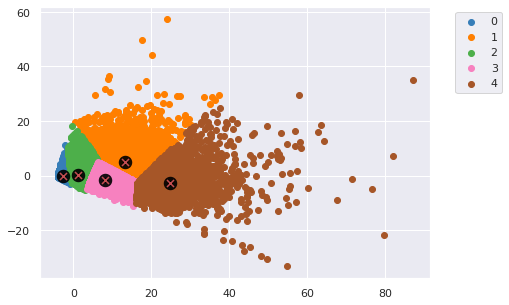

In [0]:
plot_cluster_K_mean(best_model,X_train_pca)

In [0]:
pd.DataFrame(X_train_pca).describe()

,0,1
count,1.962510e+05,1.962510e+05
mean,1.911479e-16,5.951783e-17
std,4.987974e+00,1.987212e+00
min,-4.050510e+00,-3.316705e+01
25%,-2.991660e+00,-6.582297e-01
50%,-1.700390e+00,-2.451947e-01
75%,9.343020e-01,3.515047e-01
max,8.699232e+01,5.747736e+01


In [0]:
data['cluster_kmean'] = best_model.predict(X_train_pca)
data['cluster_kmean'] .value_counts()

0    123223
2     50306
3     15456
1      4474
4      2792
Name: cluster_kmean, dtype: int64

# GMM

In [0]:
# Function to plot cluster (GMM)
def plot_centroids_2(centroids, weights=None, circle_color='black', cross_color='r'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_cluster_gmm(model,X):
  y_pred = model.predict(X)

  clusters_number=len(set(y_pred))
  print('Number cluster: ',clusters_number)

  unique_labels = set(y_pred)
  print(unique_labels)

  colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                            '#f781bf', '#a65628', '#984ea3',
                                            '#999999', '#e41a1c', '#dede00']),
                                    int(max(y_pred) + 1))))
  # add black color for outliers (if any)
  colors = np.append(colors, ["#000000"])
  #print(colors)
  i=0

  fig,ax=plt.subplots(figsize=(7,5))

  for k in unique_labels:
    plt.scatter(X[y_pred==k, 0],X[y_pred==k, 1], 
                #edgecolor='black',
                marker='o',label=k,
                c=colors[i] # Note: depend on number of cluster (max 8), if infinitive cluster, need to remove colors
                )
    i+=1
  plot_centroids_2(model.means_,model.weights_)
  plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  plt.show()

In [0]:
# Function plot_gaussian_mixture
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)
    
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Find best number of cluster

In [0]:
X_train_pca.shape

(196251, 2)

In [0]:
gms_per_k =[]
for k in range(1, 11):
  print(k)
  t1=time.time()
  temp=GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X_train_pca)
  gms_per_k.append(temp)
  t2=time.time()
  print(t2-t1)
#1 2.1949238777160645
#2 15.671762466430664
#3 42.44370460510254
#4 72.22512125968933
#5 85.08871555328369
#6 111.54287147521973
#7 115.27232766151428
#8 119.77056384086609
#9 126.1697940826416
#10 126.59603261947632

In [0]:
bics = [model.bic(X_train_pca) for model in gms_per_k]
aics = [model.aic(X_train_pca) for model in gms_per_k]

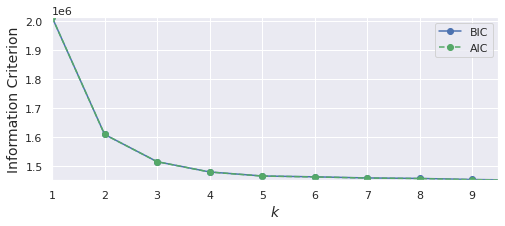

In [0]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.legend()
#save_fig("aic_bic_vs_k_plot")
plt.show()

In [0]:
k=4
t1=time.time()
gmm=GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X_train_pca)
t2=time.time()
print(t1-t2)

-70.92991161346436


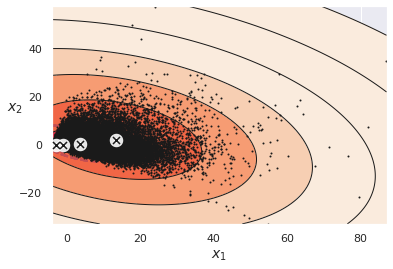

In [0]:
plot_gaussian_mixture(gmm, X_train_pca)

Number cluster:  4
{0, 1, 2, 3}


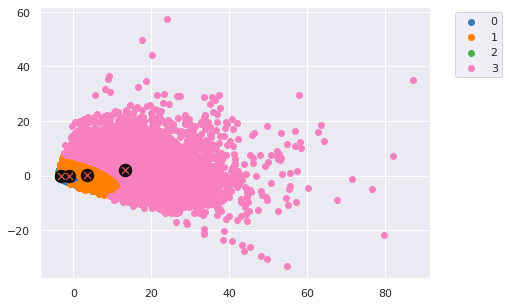

In [0]:
plot_cluster_gmm(gmm,X_train_pca)

In [0]:
data['cluster_gmm'] = gmm.predict(X_train_pca)
data['cluster_gmm'] .value_counts()

0    74685
2    72672
1    38434
3    10460
Name: cluster_gmm, dtype: int64

## Abnormal detection

Gaussian Mixtures can be used for anomaly detection: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [0]:
threshold=3

densities = gmm.score_samples(X_train_pca)
density_threshold = np.percentile(densities, threshold)
anomalies = X_train_pca[densities < density_threshold]
print(densities.shape)
print(anomalies.shape)

(196251,)
(5888, 2)


In [0]:
print(density_threshold)
pd.DataFrame(densities).describe()

-8.851410248324942


,0
count,196251.000000
mean,-3.770095
std,2.231142
min,-82.368518
25%,-5.266534
50%,-3.287076
75%,-1.962721
max,-0.956991


In [0]:
data['cluster_gmm'] .value_counts()

0    74685
2    72672
1    38434
3    10460
Name: cluster_gmm, dtype: int64

In [0]:
data['score_gmm']=densities
#data['cluster_gmm'][data['score_gmm']<density_threshold]=-1
data.loc[data['score_gmm'] <density_threshold, 'cluster_gmm'] = -1
data['cluster_gmm'].value_counts()

 0    74685
 2    72672
 1    38338
-1     5888
 3     4668
Name: cluster_gmm, dtype: int64

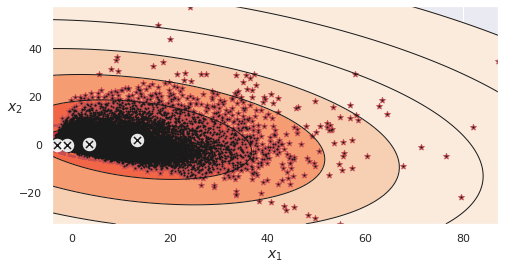

In [0]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gmm, X_train_pca)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
#plt.ylim(top=5.1)
#save_fig("mixture_anomaly_detection_plot")
plt.show()

# BIRCH

The Birch builds a tree called the Clustering Feature Tree (CFT) for the given data. The data is essentially lossy compressed to a set of Clustering Feature nodes (CF Nodes). The CF Nodes have a number of subclusters called Clustering Feature subclusters (CF Subclusters) and these CF Subclusters located in the non-terminal CF Nodes can have CF Nodes as children.

The CF Subclusters hold the necessary information for clustering which prevents the need to hold the entire input data in memory. This information includes:

Number of samples in a subcluster.

Linear Sum - A n-dimensional vector holding the sum of all samples

Squared Sum - Sum of the squared L2 norm of all samples.

Centroids - To avoid recalculation linear sum / n_samples.

Squared norm of the centroids.

In [0]:
birch =Birch(n_clusters=4)
t1=time.time()
birch.fit(X_train_pca)
t2=time.time()
print('time: ',t2-t1)

y_pred = birch.predict(X_train_pca)
clusters_number=len(set(y_pred))
print('Number cluster: ',clusters_number)

unique_labels = set(y_pred)
print(unique_labels)

time:  8.32634949684143
Number cluster:  4
{0, 1, 2, 3}


['#377eb8' '#ff7f00' '#4daf4a' '#f781bf' '#000000']


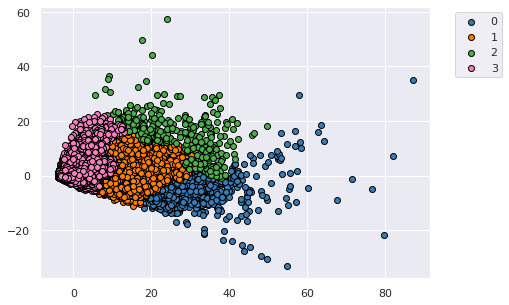

In [0]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                          '#f781bf', '#a65628', '#984ea3',
                                          '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
print(colors)

i=0
fig,ax=plt.subplots(figsize=(7,5))

for k in unique_labels:
  plt.scatter(X_train_pca[y_pred==k, 0],X_train_pca[y_pred==k, 1], 
              edgecolor='black',marker='o',label=k,
              c=colors[i] # Note: depend on number of cluster (max 8), if infinitive cluster, need to remove colors
              )
  i+=1
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

{0, 1, 2, 3}
(1311, 2)
['#377eb8' '#ff7f00' '#4daf4a' '#f781bf' '#000000']


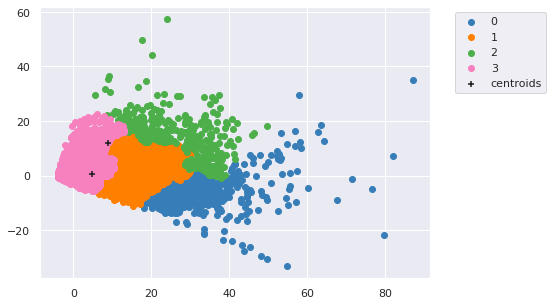

In [0]:
labels = birch.labels_
centroids = birch.subcluster_centers_
print(set(labels))
print(centroids.shape)

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                          '#f781bf', '#a65628', '#984ea3',
                                          '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
print(colors)

i=0
fig,ax=plt.subplots(figsize=(7,5))

for k in unique_labels:
  plt.scatter(X_train_pca[y_pred==k, 0],X_train_pca[y_pred==k, 1], 
              #edgecolor='black',
              marker='o',label=k,
              c=colors[i] # Note: depend on number of cluster (max 8), if infinitive cluster, need to remove colors
              )
  i+=1
plt.scatter(centroids[0], centroids[1], marker='+',
               c='k', #s=25,
            label='centroids')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


## Compare Birch and mini batch Kmeans

Automatically created module for IPython interactive environment
Birch without global clustering as the final step took 6.06 seconds
n_clusters : 265
Birch with global clustering as the final step took 6.20 seconds
n_clusters : 4
Time taken to run MiniBatchKMeans 1.79 seconds


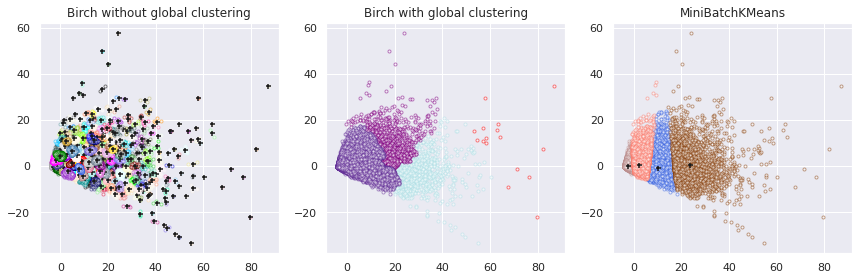

In [0]:
# Authors: Manoj Kumar <manojkumarsivaraj334@gmail.com
#          Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
# License: BSD 3 clause

print(__doc__)

from itertools import cycle
from time import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.datasets import make_blobs


# Generate blobs to do a comparison between MiniBatchKMeans and Birch.
X=X_train_pca.copy()

# Use all colors that matplotlib provides by default.
colors_ = cycle(colors.cnames.keys())

fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.1, top=0.9)

# Compute clustering with Birch with and without the final clustering step
# and plot.
birch_models = [Birch(threshold=1.7, n_clusters=None),
                Birch(threshold=1.7, n_clusters=4)]
final_step = ['without global clustering', 'with global clustering']

for ind, (birch_model, info) in enumerate(zip(birch_models, final_step)):
    t = time()
    birch_model.fit(X)
    time_ = time() - t
    print("Birch %s as the final step took %0.2f seconds" % (
          info, (time() - t)))

    # Plot result
    labels = birch_model.labels_
    centroids = birch_model.subcluster_centers_
    n_clusters = np.unique(labels).size
    print("n_clusters : %d" % n_clusters)

    ax = fig.add_subplot(1, 3, ind + 1)
    for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
        mask = labels == k
        ax.scatter(X[mask, 0], X[mask, 1],
                   c='w', edgecolor=col, marker='.', alpha=0.5)
        if birch_model.n_clusters is None:
            ax.scatter(this_centroid[0], this_centroid[1], marker='+',
                       c='k', s=25)
    #ax.set_ylim([-25, 25])
    #ax.set_xlim([-25, 25])
    ax.set_autoscaley_on(False)
    ax.set_title('Birch %s' % info)

# Compute clustering with MiniBatchKMeans.
mbk = MiniBatchKMeans(init='k-means++', n_clusters=4, batch_size=50000,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0)
t0 = time()
mbk.fit(X)
t_mini_batch = time() - t0
print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)
mbk_means_labels_unique = np.unique(mbk.labels_)

ax = fig.add_subplot(1, 3, 3)
for this_centroid, k, col in zip(mbk.cluster_centers_,
                                 range(n_clusters), colors_):
    mask = mbk.labels_ == k
    ax.scatter(X[mask, 0], X[mask, 1], marker='.',
               c='w', edgecolor=col, alpha=0.5)
    ax.scatter(this_centroid[0], this_centroid[1], marker='+',
               c='k', s=25)
#ax.set_xlim([-25, 25])
#ax.set_ylim([-25, 25])
ax.set_title("MiniBatchKMeans")
ax.set_autoscaley_on(False)
plt.show()

# HDBSCAN

In [0]:
hdbscan_ = hdbscan.HDBSCAN(min_cluster_size=200,prediction_data=True,min_samples=15,
                          #cluster_selection_epsilon
                           )

t1 = time.time()
hdbscan_.fit(X_train_pca)
t2 = time.time()
print('minibatch_kmeans: {:.3f} seconds'.format(t2-t1))

In [0]:
y_pred = hdbscan_.labels_.astype(np.int)
clusters_number=len(set(y_pred))
print('Number cluster: ',clusters_number)

unique_labels = set(y_pred)
print(unique_labels)
pd.value_counts(y_pred)

In [0]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                          '#f781bf', '#a65628', '#984ea3',
                                          '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
#print(colors)

i=0
fig,ax=plt.subplots(figsize=(7,5))

for k in unique_labels:
  plt.scatter(X_train_pca[y_pred==k, 0],X_train_pca[y_pred==k, 1], 
              #edgecolor='black',
              marker='o',label=k,
              #c=colors[i] # Note: depend on number of cluster (max 8), if infinitive cluster, need to remove colors
              )
  i+=1
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# Hierarchical clustering (not)

In [0]:
# Creash season
clusters_number = 4
t1=time.time()
ac = AgglomerativeClustering(n_clusters=clusters_number,
                             affinity='euclidean',
                             linkage='complete')
#ac.fit(X_scaled)
cluster=ac.fit_predict(X_train_pca)
t2=time.time()
print('time',t2-t1)
unique_labels = set(cluster)
print(unique_labels)


In [0]:
plot_cluster_K_mean(ac,X_train_pca)

# DBSCAN (not)

In [0]:
# Creash season

DBSCAN is particularly well suited for problems which require:

- Minimal domain knowledge to determine the input parameters (i.e. K in k-means and Dmin in hierarchical clustering)

- Discovery of clusters with arbitrary shapes

- Good efficiency on large databases

In [0]:
X_train_pca.shape

(196251, 2)

Find optimal esp

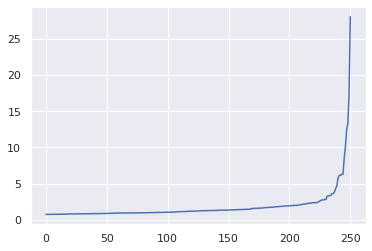

In [0]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_train_pca)
distances, indices = nbrs.kneighbors(X_train_pca)
distances = np.sort(distances, axis=0)
distances = distances[196000:,1]
plt.plot(distances)

In [0]:
t1 = time.time()
db = DBSCAN(eps=5, min_samples=10)
db.fit(X_train_pca)
t2=time.time()
print('time',t2-t1)

y_pred = db.labels_.astype(np.int)
clusters_number=len(set(y_pred))
print('Number cluster: ',clusters_number)

unique_labels = set(y_pred)
print(unique_labels)

In [0]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                          '#f781bf', '#a65628', '#984ea3',
                                          '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
print(colors)

i=0
fig,ax=plt.subplots(figsize=(7,5))

for k in unique_labels:
  plt.scatter(X_train_pca[y_pred==k, 0],X_train_pca[y_pred==k, 1], 
              edgecolor='black',marker='o',label=k,
              c=colors[i] # Note: depend on number of cluster (max 8), if infinitive cluster, need to remove colors
              )
  i+=1
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# OPTICS (not)

In [0]:
# Crash season
optics = cluster.OPTICS(min_samples=20,
                        xi=0.05,
                        min_cluster_size=0.1)
optics.fit(X_train_pca)

y_pred = optics.labels_.astype(np.int)
clusters_number=len(set(y_pred))
print('Number cluster: ',clusters_number)

unique_labels = set(y_pred)
print(unique_labels)

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                          '#f781bf', '#a65628', '#984ea3',
                                          '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
print(colors)

i=0
fig,ax=plt.subplots(figsize=(7,5))

for k in unique_labels:
  plt.scatter(X_train_pca[y_pred==k, 0],X_train_pca[y_pred==k, 1], 
              edgecolor='black',marker='o',label=k,
              c=colors[i] # Note: depend on number of cluster (max 8), if infinitive cluster, need to remove colors
              )
  i+=1
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# Check another PCA method

In [0]:
Stop here

SyntaxError: ignored

In [0]:
name_=[]
time_=[]

regular_pca = PCA(n_components=components) #suggest
inc_pca = IncrementalPCA(n_components=components, batch_size=50000)
rnd_pca = PCA(n_components=components, random_state=42, svd_solver="randomized") #suggest
#spare_pca= SparsePCA(n_components=components, random_state=0) #suggest very too long
pca_dict={"regular_pca":regular_pca,"inc_pca":inc_pca,"rnd_pca":rnd_pca,
          #"spare_pca":spare_pca
          }
for name,pca in pca_dict.items():
    print(name)
    t1 = time.time()
    pca.fit(X_scaled)
    t2 = time.time()
    print("    {}: {:.3f} seconds".format(pca.__class__.__name__, t2 - t1))
    name_.append(name)
    time_.append(t2 - t1)

#default PCA: 6.037 seconds
#IncrementalPCA: 5.479 seconds
#Random PCA: 16.571 seconds

In [0]:
# Check Incremental PCA:
for batch in (500,1000,5000,10000,50000):
  inc_pca = IncrementalPCA(n_components=components, batch_size=batch)
  t1 = time.time()
  inc_pca.fit(X_scaled)
  t2 = time.time()
  print("{}    {}: {:.3f} seconds".format(batch,pca.__class__.__name__, t2 - t1))

#500    PCA: 12.590 seconds
#1000    PCA: 8.355 seconds
#5000    PCA: 5.811 seconds
#10000    PCA: 5.462 seconds
#50000    PCA: 5.421 seconds

In [0]:
# Took: 192 s, very long
#ICA = FastICA(n_components=components, random_state=123) 
#t0 = time.time()
#X_ica=ICA.fit_transform(X_scaled)
#t1 = time.time()
#print("ICA fitting time:", round(t1-t0, 3), "s")

In [0]:
# Factor analysis: very long